# Dependencies

In [1]:
import os
import cv2
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold

# Set seeds to make the experiment more reproducible.
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
seed = 0
seed_everything(seed)

%matplotlib inline
sns.set(style="whitegrid")
warnings.filterwarnings("ignore")

# Load data

In [2]:
new_data = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
old_data = pd.read_csv('../input/diabetic-retinopathy-resized/trainLabels.csv')
test_df = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')

old_data = old_data[['image', 'level']]
old_data.columns = new_data.columns
new_data['data'] = 'new'
old_data['data'] = 'old'
old_data["id_code"] = old_data["id_code"].apply(lambda x: x + ".jpeg")
new_data["id_code"] = new_data["id_code"].apply(lambda x: x + ".png")
test_df["id_code"] = test_df["id_code"].apply(lambda x: x + ".png")

# Sample rows of diagnosis = 0
diag_0 = old_data[old_data['diagnosis'] == 0].sample(frac=0.25, random_state=seed)
diag_oth = old_data[old_data['diagnosis'] != 0]
old_data = diag_0.append(diag_oth)

train_df = new_data.append(old_data)
print('Number of train samples: ', train_df.shape[0])
print('Number of test samples: ', test_df.shape[0])
display(train_df.head())

Number of train samples:  19430
Number of test samples:  1928


,id_code,diagnosis,data
0,000c1434d8d7.png,2,new
1,001639a390f0.png,4,new
2,0024cdab0c1e.png,1,new
3,002c21358ce6.png,0,new
4,005b95c28852.png,0,new


# Hold-out train validation split (50%) of new dataset data

In [3]:
train, validation = train_test_split(new_data, test_size=0.5, random_state=seed)
train = train.append(old_data)

# Train & Validation label distribution

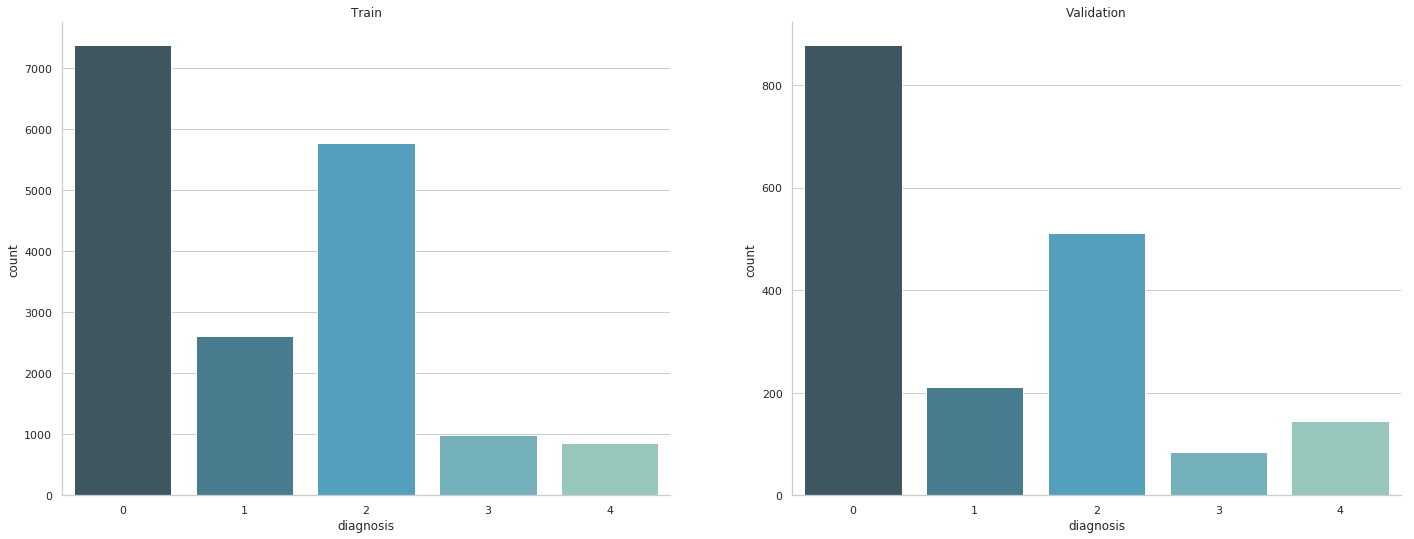

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex='col', figsize=(24, 8.7))
sns.countplot(x="diagnosis", data=train, palette="GnBu_d", ax=ax1).set_title('Train')
sns.countplot(x="diagnosis", data=validation, palette="GnBu_d", ax=ax2).set_title('Validation')
sns.despine()
plt.show()

# Output hold-out set

In [5]:
train['set'] = 'train'
validation['set'] = 'validation'
train_complete = train.append(validation)
train_complete.to_csv('hold-out_5.csv', index=False)
print('Number of train samples: ', train.shape[0])
print('Number of validation samples: ', validation.shape[0])
display(train_complete.head())

Number of train samples:  17599
Number of validation samples:  1831


,id_code,diagnosis,data,set
2213,9b70f84400af.png,0,new,train
2792,c0e509786f7f.png,4,new,train
2522,aeab0a63bcaf.png,0,new,train
3364,e97ecf4355cb.png,0,new,train
3484,f26b02ead915.png,0,new,train


# Hold-out train validation split (30%) of new dataset data

In [6]:
train, validation = train_test_split(new_data, test_size=0.3, random_state=seed)
train = train.append(old_data)

# Output hold-out set

In [7]:
train['set'] = 'train'
validation['set'] = 'validation'
train_complete = train.append(validation)
train_complete.to_csv('hold-out_3.csv', index=False)
print('Number of train samples: ', train.shape[0])
print('Number of validation samples: ', validation.shape[0])
display(train_complete.head())

Number of train samples:  18331
Number of validation samples:  1099


,id_code,diagnosis,data,set
1414,6324d77cf926.png,0,new,train
745,3599029efeb3.png,0,new,train
3516,f4e68b61f480.png,0,new,train
1490,6852f4531591.png,0,new,train
1757,7c2e852171c0.png,0,new,train


# 5-Fold split

In [8]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

for fold_n, (trn_idx, val_idx) in enumerate(folds.split(new_data, new_data['diagnosis'])):
    print('Fold: %s, Train size: %s, Validation size %s' % 
          (fold_n, len(trn_idx), len(val_idx)))
    new_data[('fold_%s' % fold_n)] = 0
    new_data[('fold_%s' % fold_n)].loc[trn_idx] = 'train'
    new_data[('fold_%s' % fold_n)].loc[val_idx] = 'validation'
    old_data[('fold_%s' % fold_n)] = 0
    old_data[('fold_%s' % fold_n)] = 'train'
    
train_df = old_data.append(new_data)
display(train_df.head())

Fold: 0, Train size: 2929, Validation size 733
Fold: 1, Train size: 2929, Validation size 733
Fold: 2, Train size: 2929, Validation size 733
Fold: 3, Train size: 2930, Validation size 732
Fold: 4, Train size: 2931, Validation size 731


,id_code,diagnosis,data,fold_0,fold_1,fold_2,fold_3,fold_4
32132,40576_left.jpeg,0,old,train,train,train,train,train
26166,33112_left.jpeg,0,old,train,train,train,train,train
25243,31961_right.jpeg,0,old,train,train,train,train,train
2010,2515_left.jpeg,0,old,train,train,train,train,train
31965,40364_right.jpeg,0,old,train,train,train,train,train


# Train & Validation label distribution

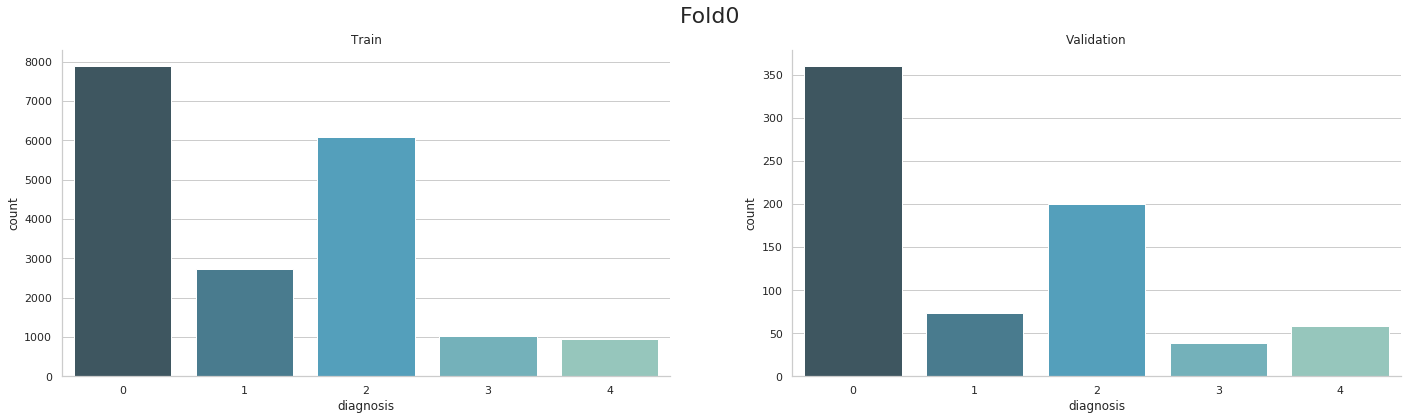

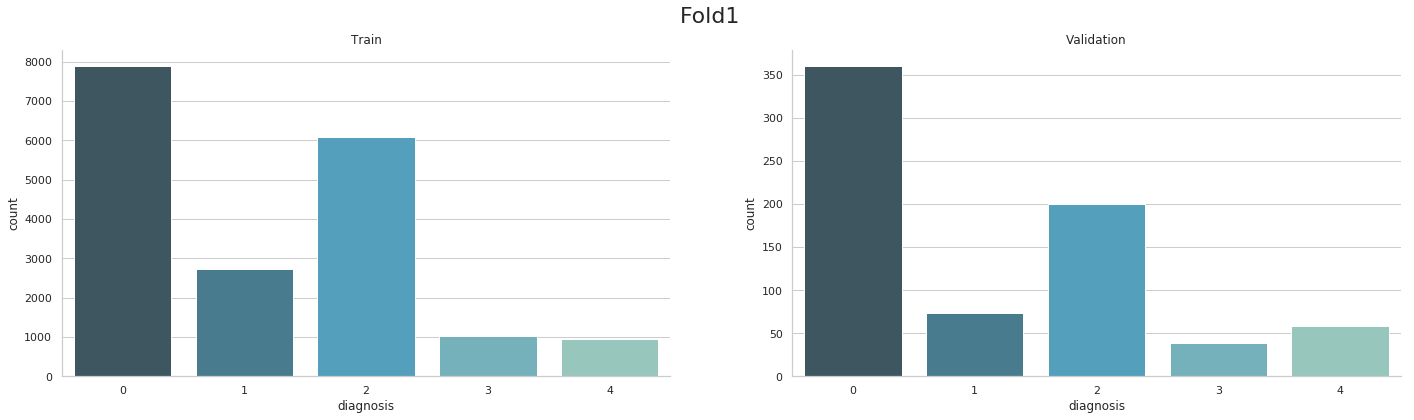

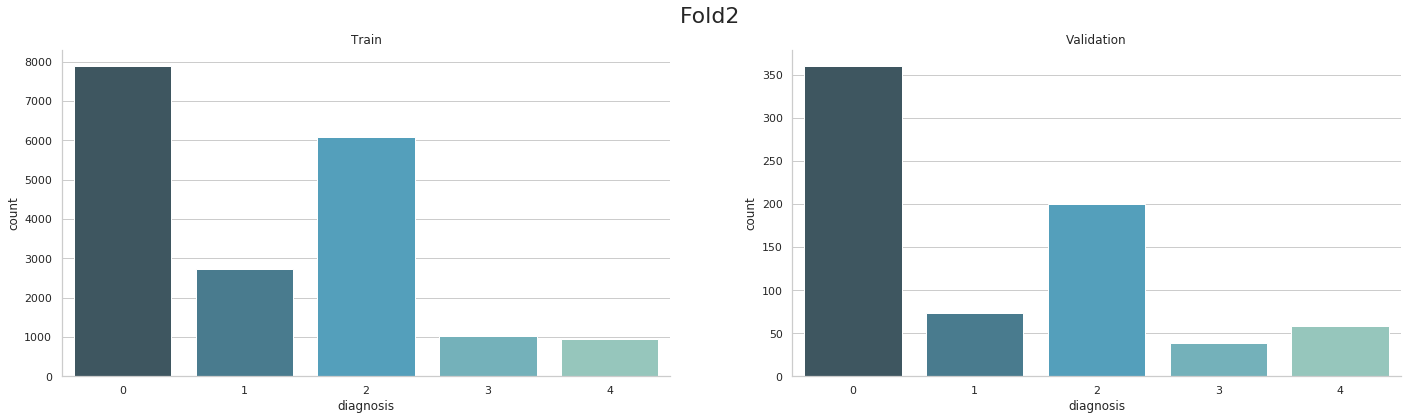

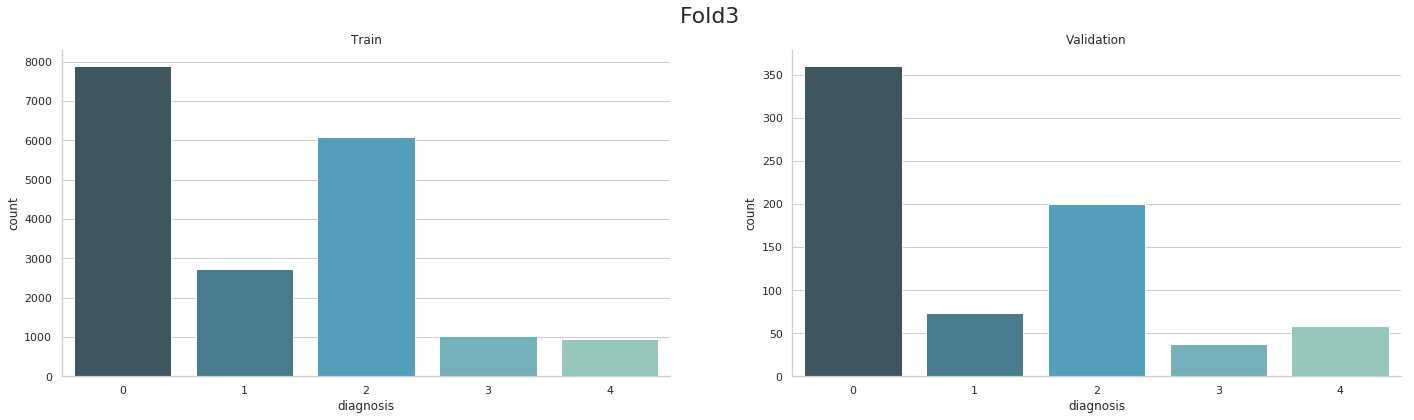

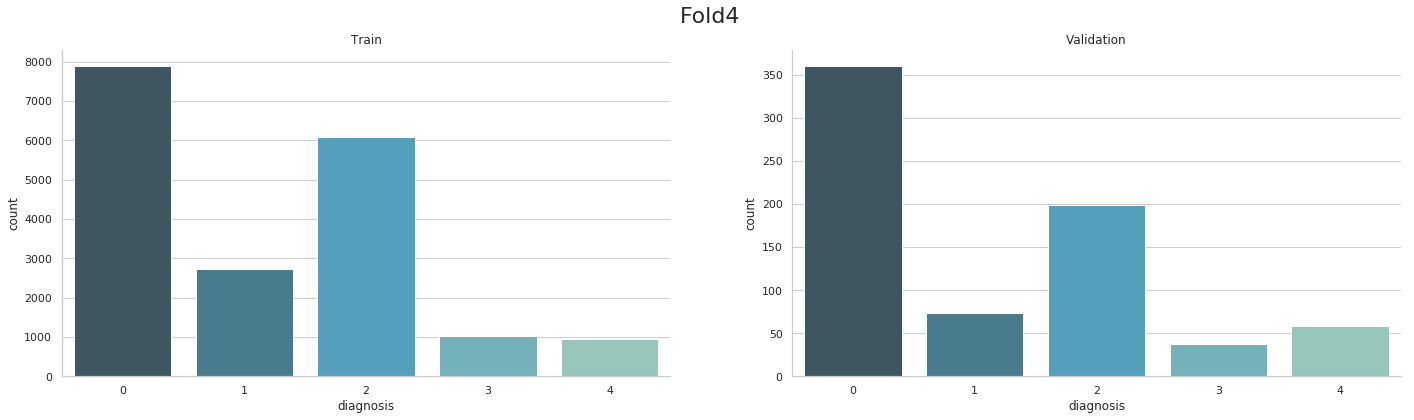

In [9]:
for fold_n, (trn_idx, val_idx) in enumerate(folds.split(train_df, train_df['diagnosis'])):
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex='col', figsize=(24, 6))
    fig.suptitle('Fold%s'%fold_n, fontsize=22)    
    sns.countplot(x="diagnosis", data=train_df[train_df[('fold_%s' % fold_n)] == 'train'], palette="GnBu_d", ax=ax1).set_title('Train')
    sns.countplot(x="diagnosis", data=train_df[train_df[('fold_%s' % fold_n)] == 'validation'], palette="GnBu_d", ax=ax2).set_title('Validation')
    sns.despine()
    plt.show()

# Output 5-fold set

In [10]:
train_df.to_csv('5-fold.csv', index=False)
print('Number of train samples: ', train_df[train_df[('fold_%s' % fold_n)] == 'train'].shape[0])
print('Number of validation samples: ', train_df[train_df[('fold_%s' % fold_n)] == 'validation'].shape[0])
display(train_df.head())

Number of train samples:  18699
Number of validation samples:  731


,id_code,diagnosis,data,fold_0,fold_1,fold_2,fold_3,fold_4
32132,40576_left.jpeg,0,old,train,train,train,train,train
26166,33112_left.jpeg,0,old,train,train,train,train,train
25243,31961_right.jpeg,0,old,train,train,train,train,train
2010,2515_left.jpeg,0,old,train,train,train,train,train
31965,40364_right.jpeg,0,old,train,train,train,train,train


# 根据标签分类
将train中的数据集对应标签分类

In [4]:
import os
import pandas as pd
import shutil

# 配置路径
images_folder = 'D:/jypterroom/data/aptos2019-blindness-detection/train_images'  # 图片文件夹路径
labels_xlsx = 'D:/jypterroom/data/aptos2019-blindness-detection/train.csv'      # 标签xlsx文件路径

# 读取xlsx文件
df = pd.read_csv(labels_xlsx)
# 假设xlsx文件中有两列：'ImageName' 和 'Label'

# 确保标签文件夹存在
for label in df['diagnosis'].unique():
    label_folder = os.path.join(str(images_folder), str(label))  # 转换为字符串
    if not os.path.exists(label_folder):
        os.makedirs(label_folder)

# 遍历图片并根据标签移动
for _, row in df.iterrows():
    image_name = str(row['id_code'])
    label = str(row['diagnosis'])
    source_path = os.path.join(images_folder, image_name+'.png')
    target_path = os.path.join(images_folder, label, image_name+'.png')
    print(source_path,target_path)
    if os.path.exists(source_path):
        shutil.move(source_path, target_path)
    else:
        print(f"Image not found: {image_name}")


D:/jypterroom/data/aptos2019-blindness-detection/train_images\000c1434d8d7.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\2\000c1434d8d7.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\001639a390f0.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\4\001639a390f0.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\0024cdab0c1e.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\1\0024cdab0c1e.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\002c21358ce6.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\002c21358ce6.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\005b95c28852.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\005b95c28852.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\0083ee8054ee.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\4\0083ee8054ee.png
D:/jypterroom/data/aptos2019-blindness-d

D:/jypterroom/data/aptos2019-blindness-detection/train_images\0a4e1a29ffff.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\0a4e1a29ffff.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\0a61bddab956.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\1\0a61bddab956.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\0a74c92e287c.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\0a74c92e287c.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\0a85a1e8f9e9.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\0a85a1e8f9e9.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\0a902c80d5da.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\0a902c80d5da.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\0a9ec1e99ce4.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\2\0a9ec1e99ce4.png
D:/jypterroom/data/aptos2019-blindness-d

D:/jypterroom/data/aptos2019-blindness-detection/train_images\1409ab48175a.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\1409ab48175a.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\1411c8ab7161.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\2\1411c8ab7161.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\1414128bead0.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\2\1414128bead0.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\141735b57ec0.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\2\141735b57ec0.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\1438288bb2e1.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\2\1438288bb2e1.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\143db89c11c8.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\143db89c11c8.png
D:/jypterroom/data/aptos2019-blindness-d

D:/jypterroom/data/aptos2019-blindness-detection/train_images\1ca35d483772.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\1ca35d483772.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\1ca62b3e4fd3.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\1ca62b3e4fd3.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\1ca91751be4d.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\1ca91751be4d.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\1caba2fb38f6.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\1caba2fb38f6.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\1cb6961d141c.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\1cb6961d141c.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\1cb814ed6332.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\2\1cb814ed6332.png
D:/jypterroom/data/aptos2019-blindness-d

D:/jypterroom/data/aptos2019-blindness-detection/train_images\260a455692b5.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\260a455692b5.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\261c6bd63bff.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\2\261c6bd63bff.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\2628305cbb29.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\4\2628305cbb29.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\262ad704319c.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\4\262ad704319c.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\263d8851e33b.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\263d8851e33b.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\26453eb7e989.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\2\26453eb7e989.png
D:/jypterroom/data/aptos2019-blindness-d

D:/jypterroom/data/aptos2019-blindness-detection/train_images\2d9d97a6e713.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\1\2d9d97a6e713.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\2da82d14e1b7.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\2da82d14e1b7.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\2db0cd3e30da.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\2db0cd3e30da.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\2dc647e00ad3.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\2dc647e00ad3.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\2dd28ac497d2.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\2dd28ac497d2.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\2df07eb5779f.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\4\2df07eb5779f.png
D:/jypterroom/data/aptos2019-blindness-d

D:/jypterroom/data/aptos2019-blindness-detection/train_images\3580a545016d.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\3580a545016d.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\358d2224de73.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\1\358d2224de73.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\3599029efeb3.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\3599029efeb3.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\359bab5d784b.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\359bab5d784b.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\35aa7f5c2ec0.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\1\35aa7f5c2ec0.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\35ac70c0d08f.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\35ac70c0d08f.png
D:/jypterroom/data/aptos2019-blindness-d

D:/jypterroom/data/aptos2019-blindness-detection/train_images\3cdda8b3df19.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\2\3cdda8b3df19.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\3cdef7c591cc.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\3cdef7c591cc.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\3ce2f8a77a32.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\3ce2f8a77a32.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\3d2ecffe0386.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\3d2ecffe0386.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\3d3e288d490e.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\2\3d3e288d490e.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\3d663a6a50a3.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\2\3d663a6a50a3.png
D:/jypterroom/data/aptos2019-blindness-d

D:/jypterroom/data/aptos2019-blindness-detection/train_images\44855f666225.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\2\44855f666225.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\44878f34e31f.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\44878f34e31f.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\4489d421e5aa.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\2\4489d421e5aa.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\44976c3b11a6.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\44976c3b11a6.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\44a4d04162cc.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\44a4d04162cc.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\44a86263117b.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\44a86263117b.png
D:/jypterroom/data/aptos2019-blindness-d

D:/jypterroom/data/aptos2019-blindness-detection/train_images\4abca30b676b.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\4\4abca30b676b.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\4ad6109706e8.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\2\4ad6109706e8.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\4ad8d3ec8789.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\4ad8d3ec8789.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\4b1001050f1d.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\2\4b1001050f1d.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\4b237b958555.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\4b237b958555.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\4b422b48d0d4.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\2\4b422b48d0d4.png
D:/jypterroom/data/aptos2019-blindness-d

D:/jypterroom/data/aptos2019-blindness-detection/train_images\5077cdb88aed.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\5077cdb88aed.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\5078caaf1f57.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\5078caaf1f57.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\50840c36f0b4.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\1\50840c36f0b4.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\5090917a2676.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\1\5090917a2676.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\50915e2329a1.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\50915e2329a1.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\50916d67bb51.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\50916d67bb51.png
D:/jypterroom/data/aptos2019-blindness-d

D:/jypterroom/data/aptos2019-blindness-detection/train_images\54bbe3da103e.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\2\54bbe3da103e.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\54bdcdecd8f3.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\54bdcdecd8f3.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\54cab3596214.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\2\54cab3596214.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\54dc6e8107cd.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\2\54dc6e8107cd.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\54f57cf26126.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\54f57cf26126.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\55034b1dbff2.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\2\55034b1dbff2.png
D:/jypterroom/data/aptos2019-blindness-d

D:/jypterroom/data/aptos2019-blindness-detection/train_images\5c7ab966a3ee.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\4\5c7ab966a3ee.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\5c817060c0ed.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\5c817060c0ed.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\5c8482926a08.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\2\5c8482926a08.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\5c85d22bd0de.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\5c85d22bd0de.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\5ca73d28f17f.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\5ca73d28f17f.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\5ca779ace6e7.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\5ca779ace6e7.png
D:/jypterroom/data/aptos2019-blindness-d

D:/jypterroom/data/aptos2019-blindness-detection/train_images\63b4d030b016.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\4\63b4d030b016.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\63b71347e95d.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\63b71347e95d.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\63c0eafd6aa9.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\63c0eafd6aa9.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\63c3c571b8ee.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\2\63c3c571b8ee.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\63c7b0265775.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\63c7b0265775.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\63d217b059b6.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\2\63d217b059b6.png
D:/jypterroom/data/aptos2019-blindness-d

D:/jypterroom/data/aptos2019-blindness-detection/train_images\6bb30ec3231a.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\6bb30ec3231a.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\6bcce181be65.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\6bcce181be65.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\6bf26b777e3a.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\6bf26b777e3a.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\6bf2a81a5d91.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\6bf2a81a5d91.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\6c00dd8bf708.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\6c00dd8bf708.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\6c250a30593b.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\4\6c250a30593b.png
D:/jypterroom/data/aptos2019-blindness-d

D:/jypterroom/data/aptos2019-blindness-detection/train_images\72c31aa48e2c.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\72c31aa48e2c.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\72d98188648f.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\4\72d98188648f.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\731b19a460ad.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\2\731b19a460ad.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\7335a2d43ada.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\1\7335a2d43ada.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\7347bd23ba80.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\7347bd23ba80.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\7347f5133a6a.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\1\7347f5133a6a.png
D:/jypterroom/data/aptos2019-blindness-d

D:/jypterroom/data/aptos2019-blindness-detection/train_images\789f0ec1eab8.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\789f0ec1eab8.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\78a577c3e0bf.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\2\78a577c3e0bf.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\78b3f819dcc5.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\4\78b3f819dcc5.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\78bcdffb8785.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\1\78bcdffb8785.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\78d53c82a23e.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\2\78d53c82a23e.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\79059d0592c4.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\2\79059d0592c4.png
D:/jypterroom/data/aptos2019-blindness-d

D:/jypterroom/data/aptos2019-blindness-detection/train_images\7f1f3269f546.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\7f1f3269f546.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\7f2123bc89a3.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\7f2123bc89a3.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\7f2cce721e19.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\7f2cce721e19.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\7f39c36469b5.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\7f39c36469b5.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\7f43becd3e83.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\7f43becd3e83.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\7f60f2a083d3.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\1\7f60f2a083d3.png
D:/jypterroom/data/aptos2019-blindness-d

D:/jypterroom/data/aptos2019-blindness-detection/train_images\84b4da14bc23.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\84b4da14bc23.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\84b79243e430.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\84b79243e430.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\84b88e8d3bca.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\84b88e8d3bca.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\84c663f39632.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\4\84c663f39632.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\84e8c62165b5.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\2\84e8c62165b5.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\851e40a21f81.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\851e40a21f81.png
D:/jypterroom/data/aptos2019-blindness-d

D:/jypterroom/data/aptos2019-blindness-detection/train_images\8906c9ed54a2.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\8906c9ed54a2.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\891329021e12.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\891329021e12.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\891392c9683c.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\2\891392c9683c.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\894a37fc3738.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\894a37fc3738.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\8958a4d17b7e.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\3\8958a4d17b7e.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\895fe2bfc5b6.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\895fe2bfc5b6.png
D:/jypterroom/data/aptos2019-blindness-d

D:/jypterroom/data/aptos2019-blindness-detection/train_images\8cb6b5b2f19c.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\2\8cb6b5b2f19c.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\8ceff4c4c860.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\8ceff4c4c860.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\8d13c46e7d75.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\8d13c46e7d75.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\8d3d67661620.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\2\8d3d67661620.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\8d4d14a4ab07.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\8d4d14a4ab07.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\8d4ff745a409.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\8d4ff745a409.png
D:/jypterroom/data/aptos2019-blindness-d

D:/jypterroom/data/aptos2019-blindness-detection/train_images\9095d43fb132.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\9095d43fb132.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\90960ddf4d14.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\90960ddf4d14.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\90a786abe58e.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\90a786abe58e.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\90a9a41eec6d.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\90a9a41eec6d.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\90b8bf342032.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\3\90b8bf342032.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\90bde2ff8953.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\90bde2ff8953.png
D:/jypterroom/data/aptos2019-blindness-d

D:/jypterroom/data/aptos2019-blindness-detection/train_images\949710bead24.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\949710bead24.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\94a67ec0714f.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\2\94a67ec0714f.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\94b1d8ad35ec.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\1\94b1d8ad35ec.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\94b9ccc73bb9.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\94b9ccc73bb9.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\94dcb491143f.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\2\94dcb491143f.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\94ef1d14597f.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\4\94ef1d14597f.png
D:/jypterroom/data/aptos2019-blindness-d

D:/jypterroom/data/aptos2019-blindness-detection/train_images\9878db94d9f3.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\3\9878db94d9f3.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\98d41bce73a8.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\98d41bce73a8.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\98e44127872f.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\98e44127872f.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\98e8adcf085c.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\2\98e8adcf085c.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\98f48850ebce.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\2\98f48850ebce.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\98f7136d2e7a.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\2\98f7136d2e7a.png
D:/jypterroom/data/aptos2019-blindness-d

D:/jypterroom/data/aptos2019-blindness-detection/train_images\9bd008aab548.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\9bd008aab548.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\9be0683649ff.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\9be0683649ff.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\9be71d6d7e59.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\9be71d6d7e59.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\9bf060db8376.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\3\9bf060db8376.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\9c088d2d1559.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\2\9c088d2d1559.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\9c14ce27cbfc.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\9c14ce27cbfc.png
D:/jypterroom/data/aptos2019-blindness-d

D:/jypterroom/data/aptos2019-blindness-detection/train_images\a04fb36db784.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\2\a04fb36db784.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\a06a63d866b2.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\a06a63d866b2.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\a06b353e7bed.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\a06b353e7bed.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\a06e41bd2634.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\2\a06e41bd2634.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\a06e5ac695ce.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\a06e5ac695ce.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\a07d571bf7ba.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\a07d571bf7ba.png
D:/jypterroom/data/aptos2019-blindness-d

D:/jypterroom/data/aptos2019-blindness-detection/train_images\a3ad6c2db6f1.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\1\a3ad6c2db6f1.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\a3b2e93d058b.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\2\a3b2e93d058b.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\a3bd2e034614.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\a3bd2e034614.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\a3d2a0c4cd17.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\1\a3d2a0c4cd17.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\a3fcf42ff56d.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\4\a3fcf42ff56d.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\a4012932e18d.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\a4012932e18d.png
D:/jypterroom/data/aptos2019-blindness-d

D:/jypterroom/data/aptos2019-blindness-detection/train_images\a80dab8eddf4.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\3\a80dab8eddf4.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\a81b06f50612.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\4\a81b06f50612.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\a821b6ecef33.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\a821b6ecef33.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\a8263d248523.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\a8263d248523.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\a82a12ad3fb1.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\a82a12ad3fb1.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\a8582e346df0.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\1\a8582e346df0.png
D:/jypterroom/data/aptos2019-blindness-d

D:/jypterroom/data/aptos2019-blindness-detection/train_images\ab3c505b624f.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\ab3c505b624f.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\ab50123abadb.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\2\ab50123abadb.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\ab653b8554c0.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\ab653b8554c0.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\ab686895533e.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\ab686895533e.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\ab724603ee93.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\ab724603ee93.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\ab78a66dee6a.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\ab78a66dee6a.png
D:/jypterroom/data/aptos2019-blindness-d

D:/jypterroom/data/aptos2019-blindness-detection/train_images\aeccef0bdc26.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\aeccef0bdc26.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\aed4e743c230.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\2\aed4e743c230.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\aeed1f251ceb.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\4\aeed1f251ceb.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\aef9016557ca.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\2\aef9016557ca.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\af133a85ea0c.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\1\af133a85ea0c.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\af345c68e836.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\af345c68e836.png
D:/jypterroom/data/aptos2019-blindness-d

D:/jypterroom/data/aptos2019-blindness-detection/train_images\b3a994760537.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\b3a994760537.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\b3c0c3330278.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\2\b3c0c3330278.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\b3d12069e1c5.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\2\b3d12069e1c5.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\b3d135bd3bb5.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\3\b3d135bd3bb5.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\b3f31c371e59.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\b3f31c371e59.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\b402b18d99a5.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\2\b402b18d99a5.png
D:/jypterroom/data/aptos2019-blindness-d

D:/jypterroom/data/aptos2019-blindness-detection/train_images\b7bd4a6627b6.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\b7bd4a6627b6.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\b7ce561a7328.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\b7ce561a7328.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\b7e0f95353f2.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\3\b7e0f95353f2.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\b7f0bc7d399e.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\b7f0bc7d399e.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\b8297a2291f5.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\b8297a2291f5.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\b82d5f1f1145.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\2\b82d5f1f1145.png
D:/jypterroom/data/aptos2019-blindness-d

D:/jypterroom/data/aptos2019-blindness-detection/train_images\bb9a3d835a94.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\1\bb9a3d835a94.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\bba38f2294a3.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\4\bba38f2294a3.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\bc23f74e14dd.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\2\bc23f74e14dd.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\bc34ed91c9bc.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\4\bc34ed91c9bc.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\bc34f52c37c7.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\bc34f52c37c7.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\bc73ce76ec43.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\1\bc73ce76ec43.png
D:/jypterroom/data/aptos2019-blindness-d

D:/jypterroom/data/aptos2019-blindness-detection/train_images\c0f15fe3b4b7.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\1\c0f15fe3b4b7.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\c102db7634d8.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\1\c102db7634d8.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\c12e9ca420a5.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\c12e9ca420a5.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\c1437a7a52c9.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\c1437a7a52c9.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\c1799a6f5c65.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\4\c1799a6f5c65.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\c1819db0aece.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\c1819db0aece.png
D:/jypterroom/data/aptos2019-blindness-d

D:/jypterroom/data/aptos2019-blindness-detection/train_images\c62cef02efa2.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\c62cef02efa2.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\c639d837f5e4.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\c639d837f5e4.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\c64c0966b4cf.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\c64c0966b4cf.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\c67117c6ab3b.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\3\c67117c6ab3b.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\c68dfa021d62.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\2\c68dfa021d62.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\c6916bc42016.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\c6916bc42016.png
D:/jypterroom/data/aptos2019-blindness-d

D:/jypterroom/data/aptos2019-blindness-detection/train_images\cc12453ea915.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\1\cc12453ea915.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\cc1eebed9276.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\2\cc1eebed9276.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\cc3d2e961768.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\4\cc3d2e961768.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\cc671a73e1cb.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\cc671a73e1cb.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\cc839823755b.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\2\cc839823755b.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\cc9270f06b65.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\1\cc9270f06b65.png
D:/jypterroom/data/aptos2019-blindness-d

D:/jypterroom/data/aptos2019-blindness-detection/train_images\d2901144070c.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\4\d2901144070c.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\d29096bd94aa.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\2\d29096bd94aa.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\d29b37d110f3.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\d29b37d110f3.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\d2afca74cbc3.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\d2afca74cbc3.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\d2c2f02bb313.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\4\d2c2f02bb313.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\d2c5fb82fe5f.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\d2c5fb82fe5f.png
D:/jypterroom/data/aptos2019-blindness-d

D:/jypterroom/data/aptos2019-blindness-detection/train_images\d6df4fe492ec.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\d6df4fe492ec.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\d6e26fe51dce.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\1\d6e26fe51dce.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\d6f36ec5564a.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\d6f36ec5564a.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\d6f6bdfd8011.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\d6f6bdfd8011.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\d7078e8b0349.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\d7078e8b0349.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\d74ccc796517.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\d74ccc796517.png
D:/jypterroom/data/aptos2019-blindness-d

D:/jypterroom/data/aptos2019-blindness-detection/train_images\d9e58e4d8689.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\d9e58e4d8689.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\da0a1043abf7.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\2\da0a1043abf7.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\da0a83f074f3.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\da0a83f074f3.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\da1fb35f5df9.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\1\da1fb35f5df9.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\da2bdf4236ac.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\da2bdf4236ac.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\da3a2275c850.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\da3a2275c850.png
D:/jypterroom/data/aptos2019-blindness-d

D:/jypterroom/data/aptos2019-blindness-detection/train_images\de778495a1cd.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\2\de778495a1cd.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\dea7538bb91a.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\dea7538bb91a.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\dec5595e6154.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\dec5595e6154.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\dee1031a76ae.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\dee1031a76ae.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\dee31065f8fe.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\dee31065f8fe.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\dee687c6e88a.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\2\dee687c6e88a.png
D:/jypterroom/data/aptos2019-blindness-d

D:/jypterroom/data/aptos2019-blindness-detection/train_images\e540d2e35d15.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\2\e540d2e35d15.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\e55188915f9d.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\1\e55188915f9d.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\e580676516b0.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\1\e580676516b0.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\e582e56e7942.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\e582e56e7942.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\e594c19e2e1d.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\e594c19e2e1d.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\e599151ca14b.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\2\e599151ca14b.png
D:/jypterroom/data/aptos2019-blindness-d

D:/jypterroom/data/aptos2019-blindness-detection/train_images\e9678824215d.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\e9678824215d.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\e96bd80a8a53.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\1\e96bd80a8a53.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\e97ecf4355cb.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\e97ecf4355cb.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\e9ab8413e771.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\4\e9ab8413e771.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\e9ce5bf645ab.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\e9ce5bf645ab.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\e9f3c85a2a02.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\e9f3c85a2a02.png
D:/jypterroom/data/aptos2019-blindness-d

D:/jypterroom/data/aptos2019-blindness-detection/train_images\ee78ce914066.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\1\ee78ce914066.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\eeaea2c5ff34.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\eeaea2c5ff34.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\eeb231c3ef1f.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\1\eeb231c3ef1f.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\eebd1e195952.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\eebd1e195952.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\eed4afc8ec83.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\1\eed4afc8ec83.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\eedae6b28f96.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\eedae6b28f96.png
D:/jypterroom/data/aptos2019-blindness-d

D:/jypterroom/data/aptos2019-blindness-detection/train_images\f4874247ede6.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\f4874247ede6.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\f4c7ae514c54.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\f4c7ae514c54.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\f4d3169b468a.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\f4d3169b468a.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\f4d3777f2710.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\2\f4d3777f2710.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\f4de9620e3f2.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\f4de9620e3f2.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\f4df3d86688d.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\f4df3d86688d.png
D:/jypterroom/data/aptos2019-blindness-d

D:/jypterroom/data/aptos2019-blindness-detection/train_images\fa748b57262b.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\2\fa748b57262b.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\fa7fa797c650.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\fa7fa797c650.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\fa9bece586fc.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\fa9bece586fc.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\fa9f1bc03f21.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\fa9f1bc03f21.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\fac399455195.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\2\fac399455195.png
D:/jypterroom/data/aptos2019-blindness-detection/train_images\fb1b8771c70a.png D:/jypterroom/data/aptos2019-blindness-detection/train_images\0\fb1b8771c70a.png
D:/jypterroom/data/aptos2019-blindness-d

# 预处理——剪裁224

In [34]:
import os
from PIL import Image
import numpy as np
from tqdm import tqdm

def preprocess_image(image_path, desired_size=224):
    im = Image.open(image_path)
    im = im.resize((desired_size, )*2, resample=Image.LANCZOS)
    return im

# 图片源文件夹和目标文件夹路径
image_folder = 'data/train_images/4/'
save_folder = 'data/processed_images/4'

# 如果目标文件夹不存在，则创建它
if not os.path.exists(save_folder):
    os.makedirs(save_folder)

# 获取图片文件夹内所有图片的名称
image_files = os.listdir(image_folder)
N = len(image_files)

# 遍历图片，进行预处理并保存
for i, image_file in enumerate(tqdm(image_files)):
    image_path = os.path.join(image_folder, image_file)
    processed_image = preprocess_image(image_path)
    
    # 保存处理后的图片到新文件夹
    save_path = os.path.join(save_folder, image_file)
    processed_image.save(save_path)


100%|████████████████████████████████████████████████████████████████████████████████| 295/295 [01:17<00:00,  3.79it/s]


In [ ]:
y_train = pd.get_dummies(train_df['diagnosis']).values

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)

In [7]:
import os
import random
from PIL import Image, ImageOps
from torchvision import transforms

# 定义一个函数来随机应用组合增强
def apply_random_transforms(image):
    # 定义可能的转换
    transformations = [
        lambda x: x,  # 无变化
        transforms.ColorJitter(brightness=0.5),
        transforms.RandomRotation(degrees=20),
        transforms.RandomHorizontalFlip(p=1.0),
        transforms.RandomVerticalFlip(p=1.0),
#         ImageOps.equalize
    ]

    # 随机选择转换的数量和转换
    num_transforms_to_apply = random.randint(1, len(transformations))
    selected_transforms = random.sample(transformations, num_transforms_to_apply)

    # 应用选定的转换
    for transform in selected_transforms:
        image = transform(image)
    return image

# 文件夹路径
folder_path = 'D:/jypterroom/data/aptos2019-blindness-detection/train_images/2/'  # 替换为你的文件夹路径
save_folder_path = 'D:/jypterroom/data/aptos2019-blindness-detection/train_images/2/'  # 保存处理后图像的路径

# 确保保存目录存在
os.makedirs(save_folder_path, exist_ok=True)

# 打印文件夹中的文件总数
print("总文件数:", len(os.listdir(folder_path)))

# 处理图片并捕获可能的错误
for filename in os.listdir(folder_path):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        try:
            image_path = os.path.join(folder_path, filename)
            image = Image.open(image_path)

            for i in range(1, 7):
                augmented_image = apply_random_transforms(image)
                augmented_image_path = os.path.join(save_folder_path, f"augmented_{i}_{filename}")
                augmented_image.save(augmented_image_path)

        except Exception as e:
            print(f"处理文件 {filename} 时出错: {e}")

# 打印处理完成的消息
print("处理完成")

总文件数: 370



KeyboardInterrupt



# 也许是最终方法？？

# 步骤1 & 步骤2: 读取CSV文件并展示标签统计图

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from tensorflow import keras
import os
from PIL import Image
import numpy as np

# 读取CSV文件
data = pd.read_csv('input/aptos2019-blindness-detection/train.csv')
labels = data['diagnosis'].tolist()

# 展示标签统计图
def show_label_distribution(labels, title):
    counter = Counter(labels)
    labels, values = zip(*counter.items())
    plt.bar(labels, values)
    plt.title(title)
    plt.show()

show_label_distribution(labels, 'Original Label Distribution')


TypeError: Descriptors cannot be created directly.
If this call came from a _pb2.py file, your generated code is out of date and must be regenerated with protoc >= 3.19.0.
If you cannot immediately regenerate your protos, some other possible workarounds are:
 1. Downgrade the protobuf package to 3.20.x or lower.
 2. Set PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python (but this will use pure-Python parsing and will be much slower).

More information: https://developers.google.com/protocol-buffers/docs/news/2022-05-06#python-updates

# 步骤3: 应用数据增强并保存增强后的图像和标签

In [ ]:
# 定义数据增强层
data_augmentation = keras.Sequential([
    keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    keras.layers.experimental.preprocessing.RandomRotation(factor=0.02),
    keras.layers.experimental.preprocessing.RandomZoom(height_factor=0.2, width_factor=0.2),
], name="data_augmentation")

# 增强图像并保存
enhanced_images = []
enhanced_labels = []
save_dir = 'enhanced_images'  # 保存增强图像的目录
os.makedirs(save_dir, exist_ok=True)
new_csv_data = {'image_path': [], 'label': []}

for index, row in data.iterrows():
    img_path = f'{image_path}.jpg'
    label = row['label']
    img = Image.open(img_path)
    img = img.resize((224, 224))  # 假设需要将图像调整为224x224
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis=0)  # 增加批次维度以适配data_augmentation
    augmented_img_array = data_augmentation(img_array)
    augmented_img = Image.fromarray(augmented_img_array[0].astype('uint8'), 'RGB')
    new_img_path = os.path.join(save_dir, f'enhanced_{os.path.basename(img_path)}')
    augmented_img.save(new_img_path)
    
    # 更新新CSV数据
    new_csv_data['image_path'].append(new_img_path)
    new_csv_data['label'].append(label)

# 保存新的CSV文件
new_data = pd.DataFrame(new_csv_data)
new_data.to_csv('enhanced_dataset.csv', index=False)


# 步骤4: 展示增强后的数据集标签统计图

In [ ]:
enhanced_labels = new_data['label'].tolist()
show_label_distribution(enhanced_labels, 'Enhanced Label Distribution')


In [1]:
import os
import cv2
import pandas as pd
import numpy as np
from tqdm import tqdm

def crop_image_from_gray(img, tol=7):
    if img.ndim == 2:
        mask = img > tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img > tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if check_shape == 0:
            return img
        else:
            img1 = img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2 = img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3 = img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3], axis=-1)
        return img

def preprocess_image(image_path, desired_size=224):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Unable to load image at {image_path}")
        return None  # 或者返回一个错误指示的图像
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = crop_image_from_gray(img)
    img = cv2.resize(img, (desired_size, desired_size))
    img = cv2.addWeighted(img, 4, cv2.GaussianBlur(img , (0,0) , desired_size/30) ,-4 ,128)
    
    return img

def preprocess_and_save(dataset, base_path, save_dir, desired_size=224):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        
    for i, row in tqdm(dataset.iterrows(), total=dataset.shape[0]):
        image_path = os.path.join(base_path, row['id_code'])
        processed_img = preprocess_image(image_path, desired_size)
        save_path = os.path.join(save_dir, row['id_code'])
        cv2.imwrite(save_path, cv2.cvtColor(processed_img, cv2.COLOR_RGB2BGR))

if __name__ == '__main__':
    im_size = 224
    new_train = pd.read_csv('input/aptos2019-blindness-detection/train.csv')
    old_train = pd.read_csv('input/diabetic-retinopathy-resized/trainLabels.csv')
    
    old_train = old_train[['image','level']]
    old_train.columns = ['id_code', 'diagnosis']
    new_train['id_code'] += '.png'
    old_train['id_code'] += '.jpeg'
    
    # Update paths according to your directory structure
#     preprocess_and_save(new_train, 'input/aptos2019-blindness-detection/train_images/', './preprocessed/new_train/', im_size)
    preprocess_and_save(old_train, 'input/diabetic-retinopathy-resized/resized_train/', './preprocessed/old_train/', im_size)


100%|████████████████████████████████████████████████████████████████████████████| 35126/35126 [26:48<00:00, 21.83it/s]
